# Now just using DF directly
## no longer need to parse separately into lists etc.  all done internally
## TO Do the dump load and initialize the DB, need to make sure correct order pf tables is loaded first those with no dependencies and then increasingly so.
## now only erroring on original 3 .txt noted by Ian Gorton in original commnication
- - 1. Conf
- - 2. Pub , Keys, Authors, Affiliations (use sets to create unique ones but may change to all .unique)
- - 3. Composites (Many to Many)
- - 4. Paper/abstracts



In [1]:
import sqlite3
import pandas as pd

In [2]:
import sqlcommands as cmd
cmd = reload(cmd)

(1548, 7)
(1548, 7)


In [6]:
df = cmd.createTOTALTable()
df.iloc[50:60]

,Abstract,Author affiliation,Authors,Conf,Title,terms,year
50,The past 20 years has seen significant investm...,"IBM Software Group, Raleigh, NC, United States...","['Brown, Alan W', '', '', ' McDermid, John A',...",ECSA,The art and science of software architecture,"['Failure analysis', 'Systems engineering', 'O...",2007
51,"Nowadays, Wireless Sensor Networks WSN are a...",Divisi n de Sistemas e Ingenier a Electr nica ...,"['Losilla, Fernando', '', '', 'Vicente Chicote...",ECSA,Wireless sensor network application developmen...,"['Mathematical models', 'Software architecture...",2007
52,Automated services help enterprises create new...,"INFOLAB, Tilburg University, Dept of Informat...","['Papazoglou, Michael P', '', '']",ECSA,What s in a service,"['Condition monitoring', 'Electronic commerce'...",2007
53,The term co evolution describes the symbiotic ...,"University of St Andrews, St Andrews, KY16 9SX...","['Morrison, Ron', '', '', 'Balasubramaniam, Dh...",ECSA,An active architecture approach to dynamic sys...,"['Dynamical systems', 'Grid computing', 'Senso...",2007
54,Software architecture views represent the basi...,Department of Information Systems and Computat...,"['Cordero, Rogelio Limon', '', '', 'Salavert, ...",ECSA,Analyzing styles of the modular software archi...,"['Computer aided design', 'Requirements engine...",2007
55,"Currently, most software systems have a dynami...",Department of Information Systems and Computat...,"['Costa, Crist bal', '', '', 'Ali, Nour', '', ...",ECSA,Dynamic reconfiguration of software architectu...,"['Computer aided design', 'Object oriented pro...",2007
56,We propose a pattern based software developmen...,Department of Computational and Cognitive Scie...,"['C t , Isabelle', '', '', 'Heisel, Marina', '...",ECSA,Pattern based evolution of software architectures,"['Pattern recognition', 'Requirements engineer...",2007
57,Most of the research in the area of multimodal...,"Department of Computer Science, Technische Uni...","['Pereira, Alessandro Costa', ' ,', '', ' Hart...",ECSA,A distributed staged architecture for multimod...,"['Computer programming languages', 'Distribute...",2007
58,The vast diversity of implementation and suppo...,"Computer Languages and Systems II Department, ...","['L pez Sanz, Marcos', '', '', 'Acu a, C sar J...",ECSA,UML profile for the platform independent model...,"['Computer simulation', 'Computer software por...",2007
59,No abstract available,None,"['Dauvin, Jean Claude', ' Romana, Louis Alexan...",ECSA,Hydrobiologia Preface,[nan],2007


In [ ]:
with sqlite3.connect('Abstracts_DB.db') as con:
    con.row_factory = sqlite3.Row
   
   cur = con.cursor()
   cur.execute("select * from students")
   
   rows = cur.fetchall();
   return render_template("list.html",rows = row

In [4]:
#don't need 
#df1 = cmd.getPatentDataFrame(hdffile='../DataBaseParsing/DFstore4.h5') 

In [5]:
df.iloc[0]['Author affiliation']

u'DISP, Univ  of Rome, Rome, Italy'

# Create the Conf Table

In [4]:
confDF = cmd.createConfTable(df)

Opened Abstracts_DB.db database successfully
Created DataFrame
Records created successfully


In [5]:
confDF
confDF.to_

,confID,confName
0,1,ECSA
1,2,QoSA
2,3,WICSA


# Create publications Table
## Now can parse all the orginal .txt with exception of the same 3  Ian gorton noted were errant

In [8]:
pubDF = cmd.createPublicationsTable(df)

Opened Abstracts_DB.db database successfully
table dropped
Created PUBLICATIONS table
Created DataFrame
Records created successfully


In [31]:
pubDF
#pubDF.to_csv('Tables_v1/publications.csv', sheet_name = 'publications')

,pubID,year,confName
0,1,2007,ECSA
1,2,2008,ECSA
2,3,2009,ECSA
3,4,2010,ECSA
4,5,2011,ECSA
5,6,2012,ECSA
6,7,2013,ECSA
7,8,2014,ECSA
8,9,2005,QoSA
9,10,2006,QoSA


# Create Keys Table

## There are errors here and I have spent way to ong trying to figure if out.  
## Somewhere the abstracts are being split into the terms.

In [10]:
keys = cmd.createKEYSTable(df)

Opened Abstracts_DB.db database successfully
              keyword
0     Loose couplings
1   aspectual concept
2       Discrete time
3  Polyacrylonitriles
4     Tacit knowledge
Created DataFrame
Records created successfully


In [32]:
print len(keys)
print len(keys.keyword.unique())
keys.iloc[50:75]
keys.head(20)

8399
8399


,keyID,keyword
0,1,Loose couplings
1,2,aspectual concept
2,3,Discrete time
3,4,Polyacrylonitriles
4,5,Tacit knowledge
5,6,microphytobenthos)
6,7,centered around the Spectrum Access System (SA...
7,8,Radiation Measuring Instruments
8,9,advanced communication technology
9,10,Automotive companies


# Authors
## I don't know how to parse them better!  Each text file seems to look at them differently and no idea what to do

In [12]:
authorsDF = cmd.createAUTHORSTable(df)

Opened Abstracts_DB.db database successfully
Author set created
Records created successfully


In [33]:
print len(authorsDF.AuthorName.drop_duplicates())  #<<--- double check!  will keep one 'empty ' ' becuase of set)
authorsDF.head()

2911


,authorID,AuthorName
0,1,Kolb Ronny
1,2,Von Massow Robert
2,3,Smiley Karen
3,4,Prakash Jai
4,5,Zhang Hongye


# Affiliation Table
## simple no extra parsing do to differences between entries

In [14]:
affilDF= cmd.createAFFILIATIONTable(df)

Opened Abstracts_DB.db database successfully
Created DataFrame
Records created successfully


In [34]:
affilDF.head()
#affilDF.to_csv('Tables_v1/affiliations.csv', sheet_name = 'affilations')

,affilID,affiliation
0,1,"DISP, Univ of Rome, Rome, Italy"
1,2,"LSTS ENIT, Tunis, Tunisia"
2,3,"INRIA, Univ des Sci et Technol de Lille, Vi..."
3,4,"Sch of Comput Sci , Univ of Adelaide, Adela..."
4,5,"Software Group, IBM, Raleigh, NC, United States"


# PAPER TABLE
## should this actually be made by first doing a join or something with the pub table?

In [35]:
paperDF= cmd.createPAPERTable(df)

Opened Abstracts_DB.db database successfully
table dropped
Created PAPER table
Created DataFrame
Records created successfully


In [36]:
paperDF.head()
#paperDF.to_csv('Tables_v1/paper.csv', sheet_name = 'paper')

,paperID,abstract,title,terms,authors,affiliation,pubYear,confName
0,1,A Software Product Line SPL is a family of r...,On the need of safe software product line arch...,"['Software design', 'Structural properties', '...","['Lopez Herrejon, Roberto E', '', '', ' Egyed,...",Institute for Systems Engineering and Automati...,2010,ECSA
1,2,A Software Product Line SPL is a portfolio o...,Feature model to product architectures Applyi...,"['Architecture', 'Computer software', 'Network...","['Perovich, Daniel', '', '', 'Rossel, Pedro O'...","CS Department, Universidad de Chile, Santiago,...",2009,ECSA
2,3,A Software Product Line SPL is a portfolio o...,Feature model to product architectures Applyi...,"['Architecture', 'Computer software', 'Network...","['Perovich, Daniel', '', '', 'Rossel, Pedro O'...","CS Department, Universidad de Chile, Santiago,...",2009,WICSA
3,4,A Software Product Line SPL is a portfolio o...,Feature model to product architectures Applyi...,"['Architecture', 'Computer software', 'Network...","['Perovich, Daniel', '', '', 'Rossel, Pedro O'...","CS Department, Universidad de Chile, Santiago,...",2011,WICSA
4,5,"A catalyst for anode oxidation of methanol, ca...",Carbon supported Pt shell modified PdCo core w...,"['Cerium alloys', 'Chronoamperometry', 'Cyclic...","['Wang, Rongfang', ' ,', '', ' Wang, Hui', ' ,...",Key Laboratory of Eco Environment Related Poly...,2010,ECSA


# PAPERKEY COMPOSITE

In [37]:
pk = cmd.createPAPERKEYTable(paperDF)

Opened Abstracts_DB.db database successfully
Records created successfully


In [38]:
pk.head()
pk.to_csv('Tables_v1/paperKey.csv', sheet_name = 'paperKey')

In [20]:
pk.tail()

,paperID,keyword
25672,1486,u'Carbon corrosion'
25673,1486,u'Chemical Products Generally'
25674,1486,u'Optical Devices and Systems'
25675,1486,u'Fuel cells'
25676,1486,u'Transmission electron microscopy'


In [21]:
pk.merge(paperDF[['paperID', 'confName']], on = 'paperID').head(15)

,paperID,keyword,confName
0,1,u'Research challenges',ECSA
1,1,u'Software product line architecture',ECSA
2,1,u'Materials Science',ECSA
3,1,u'Structural properties',ECSA
4,1,u'Software product lines',ECSA
5,1,u'Software systems',ECSA
6,1,u'Software design',ECSA
7,1,u'Product-lines',ECSA
8,1,u'Computer Programming',ECSA
9,1,u'Feature models',ECSA


# Affiliation_Paper Composite 
## necessary?

In [39]:
paperAffiliationDF = cmd.createAFFILIATIONPAPERTable(paperDF, affilDF)

Opened Abstracts_DB.db database successfully
Records created successfully


In [40]:
paperAffiliationDF.tail()
#paperAffiliationDF.to_csv('Tables_v1/paperAffiliation.csv', sheet_name = 'paperAffil')

,paperID,affilID
1481,1482,1107
1482,1483,379
1483,1484,379
1484,1485,971
1485,1486,412


In [41]:
paperDF[['paperID', 'pubYear']].merge(paperAffiliationDF, on = 'paperID').tail()

,paperID,pubYear,affilID
1481,1482,2014,1107
1482,1483,2012,379
1483,1484,2012,379
1484,1485,2005,971
1485,1486,2012,412


# PAPERAUTHORS COMPOSITE

In [42]:
authorPaper = cmd.createPAPERAUTHORTable(paperDF[['paperID', 'authors']])
#authorPaper.to_csv('Tables_v1/authorPaper.csv', sheet_name = 'paperAuthor')

Opened Abstracts_DB.db database successfully
Records created successfully


In [43]:
authorPaper.head(20)

,paperID,authorName
0,1,"Lopez Herrejon, Roberto E"
1,1,"Egyed, Alexander"
2,2,"Perovich, Daniel"
3,2,"Rossel, Pedro O"
4,2,"Bastarrica, Mar a Cecilia"
5,3,"Perovich, Daniel"
6,3,"Rossel, Pedro O"
7,3,"Bastarrica, Mar a Cecilia"
8,4,"Perovich, Daniel"
9,4,"Rossel, Pedro O"


In [44]:
paperDF[['paperID', 'title']].merge(authorPaper, on = 'paperID').head(20)

,paperID,title,authorName
0,1,On the need of safe software product line arch...,"Lopez Herrejon, Roberto E"
1,1,On the need of safe software product line arch...,"Egyed, Alexander"
2,2,Feature model to product architectures Applyi...,"Perovich, Daniel"
3,2,Feature model to product architectures Applyi...,"Rossel, Pedro O"
4,2,Feature model to product architectures Applyi...,"Bastarrica, Mar a Cecilia"
5,3,Feature model to product architectures Applyi...,"Perovich, Daniel"
6,3,Feature model to product architectures Applyi...,"Rossel, Pedro O"
7,3,Feature model to product architectures Applyi...,"Bastarrica, Mar a Cecilia"
8,4,Feature model to product architectures Applyi...,"Perovich, Daniel"
9,4,Feature model to product architectures Applyi...,"Rossel, Pedro O"


In [28]:
from flask import *

In [45]:
confDF.to_html()

u'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>confID</th>\n      <th>confName</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>1</td>\n      <td>ECSA</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>2</td>\n      <td>QoSA</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>3</td>\n      <td>WICSA</td>\n    </tr>\n  </tbody>\n</table>'

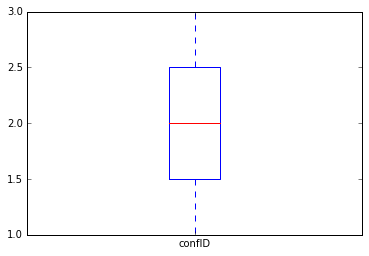

In [51]:
confDF.plot(kind = 'box')

In [48]:
%matplotlib inline

Queries:
As for the given queries: 
papers with key word grouped by year.   
- PaperID ---> KeywordFK, PaperID --> PublicationID:year

author's most buzzy words : 
- authorID ---> paperID -->KeyWordId (count) (sort).max

paper's affiliation grouped by conference and year  ??
- paper ID:affiliation ---> publicationID:year -->ConferenceID:type

conference/year and the keywords in order of frequency (ie word cloud visualization maybe?)  <<_--this might break it?
- confID -->publicationID --> PaperIDs-->KeywordIDs (count) (sort descending)

Affiliation's authors
- authorsID--: papersIds: affiliation  (i need to check if an author can have multiple affiliations, I can't see why not if they change universities or companies after 10 years)


Most frequent affiliations per conference
paperIDs: affiliation --> publicationIDs --> ConferenceID

In [67]:
q1 = pk.merge(paperDF[['paperID', 'pubYear']], on = 'paperID')


In [70]:
len(q1['keyword'].unique())

8166

In [76]:
len(authorPaper)

5033

In [83]:
authorAffiliation = authorPaper.merge(paperDF[['paperID', 'affiliation', 'pubYear']])

In [88]:
authorAffiliation.query('"Muccini, Henry" in authorName').sort('pubYear')

/Users/aileennovero1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,paperID,authorName,affiliation,pubYear
1395,418,"Muccini, Henry","Dipartimento di Informatica, University of L A...",2007
2783,857,"Muccini, Henry","Dipartimento di Informatica, Universit degli ...",2008
1496,444,"Muccini, Henry","Dipartimento di Informatica, University of l A...",2010
18,6,"Muccini, Henry","Dipartimento di Informatica, Universit dell A...",2012
22,7,"Muccini, Henry","Dipartimento di Informatica, Universit dell A...",2012
1644,494,"Muccini, Henry","Dipartimento di Informatica, University of l A...",2012
1646,495,"Muccini, Henry","Dipartimento di Informatica, University of l A...",2012
198,48,"Muccini, Henry","Department of Information Engineering, Compute...",2014
4917,1448,"Muccini, Henry","Amrita Vishwa Vidyapeetham, India 2 Universi...",2014


In [92]:
#paper's affiliation grouped by conference and year ??
papafiil = paperAffiliationDF.merge(paperDF[['paperID', 'pubYear', 'confName']], on = 'paperID')

In [94]:
groupPA = papafiil.groupby(['pubYear', 'confName'])

In [103]:
groupPA.aggregate('count')

paperID  affilID
pubYear confName                  
2004    WICSA          69       69
2005    QoSA           21       21
        WICSA          69       69
2006    QoSA           30       30
2007    ECSA           96       96
        QoSA           12       12
        WICSA          71       71
2008    ECSA          119      119
        QoSA           41       41
        WICSA          46       46
2009    ECSA           64       64
        QoSA           12       12
        WICSA          50       50
2010    ECSA          133      133
        QoSA           12       12
2011    ECSA           53       53
        QoSA           19       19
        WICSA          50       50
2012    ECSA          118      118
        QoSA           18       18
        WICSA          83       83
2013    ECSA          112      112
        QoSA           17       17
2014    ECSA          106      106
        QoSA           18       18
        WICSA          47       47

In [ ]:
conf